In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch import optim

# Data

In [4]:
raw_df = pd.read_csv('AMZN.csv')
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6257 non-null   datetime64[ns]
 1   Open       6257 non-null   float64       
 2   High       6257 non-null   float64       
 3   Low        6257 non-null   float64       
 4   Close      6257 non-null   float64       
 5   Adj Close  6257 non-null   float64       
 6   Volume     6257 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 342.3 KB


In [5]:
train_df = raw_df[raw_df['Date'] < '2019-01-01']
val_df = raw_df[(raw_df['Date'] >= '2019-01-01') & (raw_df['Date'] < '2021-01-01')]
test_df = raw_df[(raw_df['Date'] >= '2021-01-01')]

#High Data
train_price_df = train_df[['High']]
val_price_df = val_df[['High']]
test_price_df = test_df[['High']]

## Data visualization

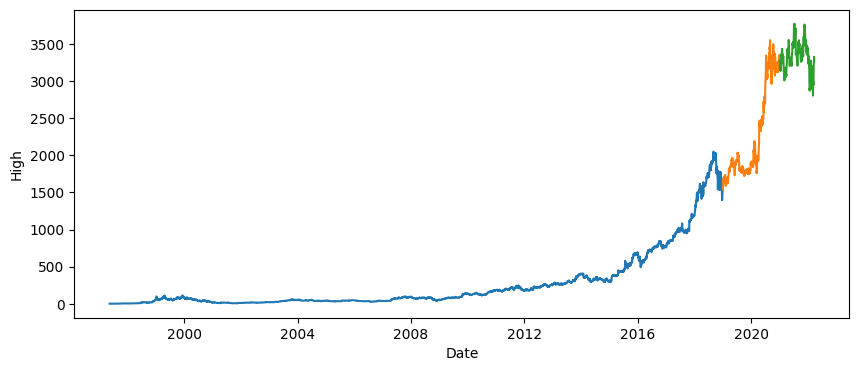

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.lineplot(data=train_df, x='Date', y='High')
sns.lineplot(data=val_df, x='Date', y='High')
sns.lineplot(data=test_df, x='Date', y='High');

# Preprocessing

## Scaler

In [7]:
sc = MinMaxScaler()
train_price_df = sc.fit_transform(train_price_df)
val_price_df = sc.fit_transform(val_price_df)
test_price_df = sc.fit_transform(test_price_df)

In [8]:
print(train_price_df.shape, val_price_df.shape, test_price_df.shape)

(5443, 1) (505, 1) (309, 1)


## Create data from X days

In [9]:
def transform_data(stock, lookback, lookforward=0, debug=False):
    data_raw = stock
    data = []

    for index in range(len(data_raw) - lookback - lookforward):
        if lookforward != 0:
            slice_to_append = data_raw[index: index + lookback - 1]
            slice_to_append = np.append(slice_to_append, data_raw[index + lookback + lookforward:index + lookback + lookforward + 1], axis=0)
        else:
            slice_to_append = data_raw[index: index + lookback]
        data.append(slice_to_append)

    data = np.array(data)
    if debug:
        print(slice_to_append, slice_to_append.shape)
        print(data.shape)
    x_train = data[:, :-1, :]
    y_train = data[:, -1, :]

    return x_train, y_train

In [10]:
num_hidden = 60
x_train, y_train = transform_data(train_price_df, num_hidden)
x_val, y_val = transform_data(val_price_df, num_hidden)
x_test, y_test = transform_data(test_price_df, num_hidden)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)

x_train.shape =  (5383, 59, 1)
y_train.shape =  (5383, 1)


## Torch tensor

In [11]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)

x_val_tensor = torch.from_numpy(x_val).type(torch.Tensor)
y_val_tensor= torch.from_numpy(y_val).type(torch.Tensor)

x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_test_tensor= torch.from_numpy(y_test).type(torch.Tensor)

# Processing

## Model

In [12]:
class LSTM(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = num_hiddens
        self.num_layers = num_layers

        self.lstm = nn.LSTM(num_inputs, num_hiddens, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(num_hiddens, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [13]:
model = LSTM(1, 32, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
for epoch in range(50):
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{50}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.070296
Epoch [2/50], Loss: 0.036748
Epoch [3/50], Loss: 0.054734
Epoch [4/50], Loss: 0.036909
Epoch [5/50], Loss: 0.032731
Epoch [6/50], Loss: 0.034332
Epoch [7/50], Loss: 0.034926
Epoch [8/50], Loss: 0.032253
Epoch [9/50], Loss: 0.026064
Epoch [10/50], Loss: 0.016859
Epoch [11/50], Loss: 0.010513
Epoch [12/50], Loss: 0.023795
Epoch [13/50], Loss: 0.004601
Epoch [14/50], Loss: 0.004904
Epoch [15/50], Loss: 0.009684
Epoch [16/50], Loss: 0.012125
Epoch [17/50], Loss: 0.010641
Epoch [18/50], Loss: 0.006099
Epoch [19/50], Loss: 0.001754
Epoch [20/50], Loss: 0.002860
Epoch [21/50], Loss: 0.006668
Epoch [22/50], Loss: 0.004102
Epoch [23/50], Loss: 0.001198
Epoch [24/50], Loss: 0.001133
Epoch [25/50], Loss: 0.002304
Epoch [26/50], Loss: 0.003250
Epoch [27/50], Loss: 0.003395
Epoch [28/50], Loss: 0.002760
Epoch [29/50], Loss: 0.001722
Epoch [30/50], Loss: 0.000840
Epoch [31/50], Loss: 0.000573
Epoch [32/50], Loss: 0.000896
Epoch [33/50], Loss: 0.001247
Epoch [34/50], Loss

## Model visualization

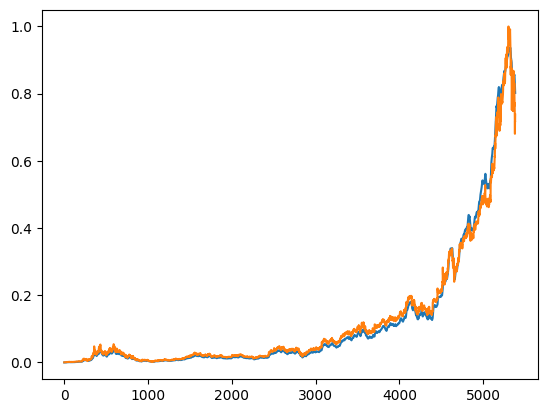

In [15]:
train_preds = model(x_train_tensor).detach().numpy()
plt.plot(train_preds)
plt.plot(y_train);

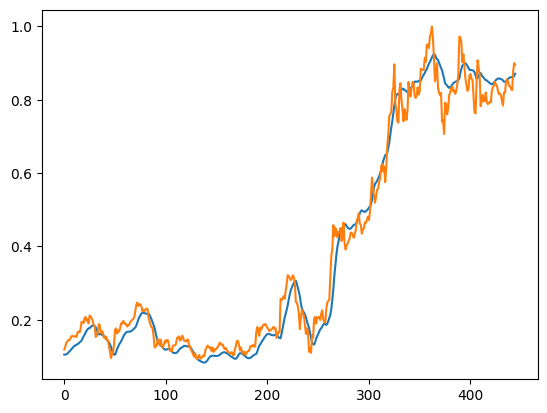

In [16]:
y_preds = model(x_val_tensor).detach().numpy()
plt.plot(y_preds)
plt.plot(y_val);

## Predictions

In [17]:
def predict(day: int = 0, predict_days: int = 50, modelo=model) -> np.array:
    x = torch.unsqueeze(x_val_tensor[day], dim=0)
    y_preds = []
    for _ in range(predict_days):
        y_pred = modelo(x)
        y_preds.append(y_pred.detach().numpy())
        
        x = torch.cat((x[:, 1:, :], y_pred.unsqueeze(1)), dim=1)

    y_preds_combined = np.squeeze(y_preds)

    return y_preds_combined

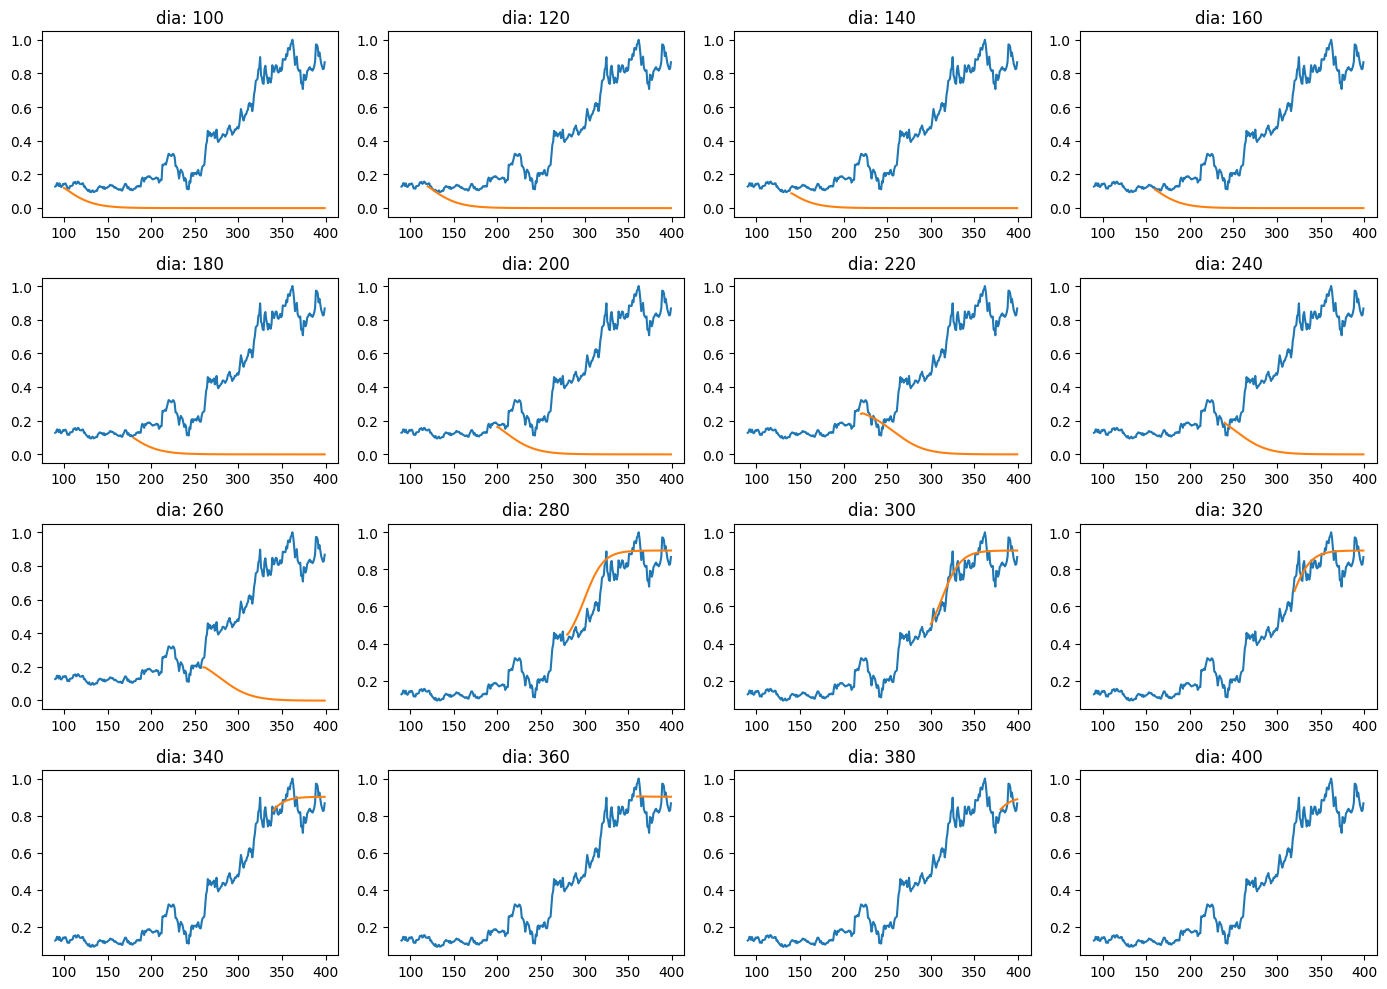

In [18]:
dia_a_predecir = 100
dias_a_predecir = 300
iterx = 20

fig, ax = plt.subplots(4, 4, figsize=(14, 10))
for _ in range(16):
    i = _ // 4
    j = _ % 4

    dia = dia_a_predecir + iterx * _
    predict_days = dias_a_predecir - iterx * _
    y0 = predict(dia, predict_days)

    sns.lineplot(x=np.arange(dia_a_predecir - 10, dia_a_predecir + dias_a_predecir), y=np.squeeze(y_val[dia_a_predecir-10:dia_a_predecir+dias_a_predecir]), legend=False, ax=ax[i, j])
    sns.lineplot(x=np.arange(dia, dia + predict_days), y=y0, label='Predictions', legend=False, ax=ax[i, j])

    ax[i, j].set_title(f"dia: {dia}")

plt.tight_layout()
plt.show()

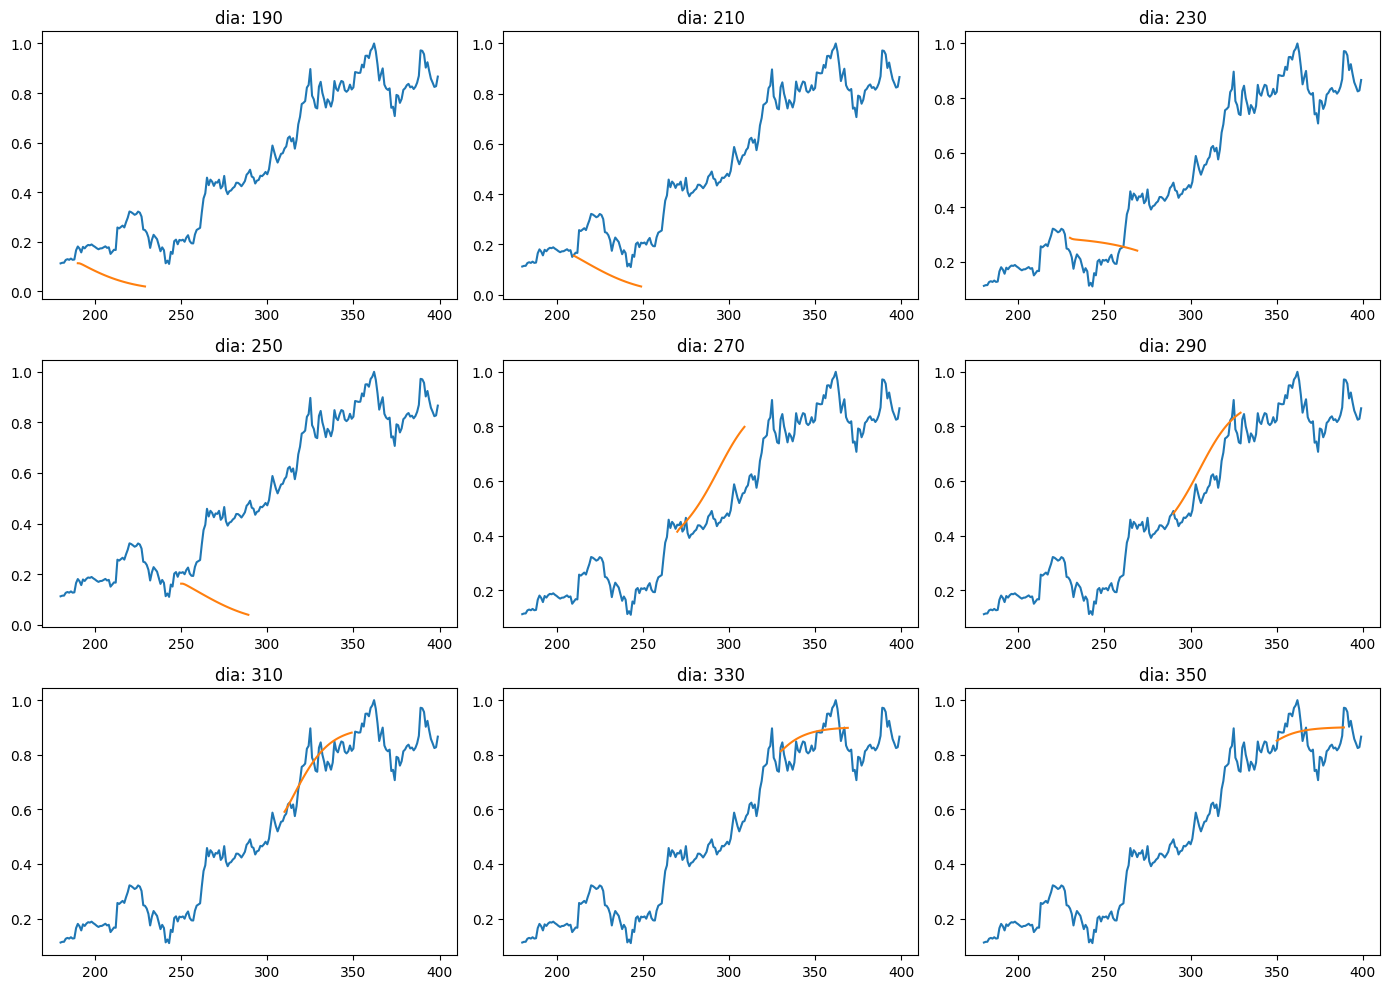

In [19]:
dia_a_predecir = 190
dias_a_predecir = 200
iterx = 20

fig, ax = plt.subplots(3, 3, figsize=(14, 10))
for _ in range(9):
    i = _ // 3
    j = _ % 3

    dia = dia_a_predecir + iterx * _
    predict_days = dias_a_predecir - iterx * _
    y0 = predict(dia, predict_days)

    sns.lineplot(x=np.arange(dia_a_predecir - 10, dia_a_predecir + dias_a_predecir + 10), y=np.squeeze(y_val[dia_a_predecir-10:dia_a_predecir+dias_a_predecir+10]), legend=False, ax=ax[i, j])
    sns.lineplot(x=np.arange(dia, dia + predict_days)[:40], y=y0[:40], label='Predictions', legend=False, ax=ax[i, j])

    ax[i, j].set_title(f"dia: {dia}")

plt.tight_layout()
plt.show()

## Future model (10 days)

In [20]:
num_hidden = 60
x_train, y_train = transform_data(train_price_df, num_hidden, 10)
x_test, y_test = transform_data(test_price_df, num_hidden, 10)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)

x_train.shape =  (5373, 59, 1)
y_train.shape =  (5373, 1)


In [21]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

In [22]:
model2 = LSTM(1, 32, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

In [23]:
for epoch in range(50):
    outputs = model2(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{50}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.038902
Epoch [2/50], Loss: 0.044510
Epoch [3/50], Loss: 0.034048
Epoch [4/50], Loss: 0.037885
Epoch [5/50], Loss: 0.031982
Epoch [6/50], Loss: 0.027035
Epoch [7/50], Loss: 0.024054
Epoch [8/50], Loss: 0.015894
Epoch [9/50], Loss: 0.001972
Epoch [10/50], Loss: 0.040742
Epoch [11/50], Loss: 0.003013
Epoch [12/50], Loss: 0.008872
Epoch [13/50], Loss: 0.013661
Epoch [14/50], Loss: 0.012912
Epoch [15/50], Loss: 0.011219
Epoch [16/50], Loss: 0.010552
Epoch [17/50], Loss: 0.010908
Epoch [18/50], Loss: 0.011492
Epoch [19/50], Loss: 0.011272
Epoch [20/50], Loss: 0.009503
Epoch [21/50], Loss: 0.006360
Epoch [22/50], Loss: 0.003134
Epoch [23/50], Loss: 0.001569
Epoch [24/50], Loss: 0.002393
Epoch [25/50], Loss: 0.004009
Epoch [26/50], Loss: 0.004102
Epoch [27/50], Loss: 0.003019
Epoch [28/50], Loss: 0.002647
Epoch [29/50], Loss: 0.003146
Epoch [30/50], Loss: 0.003117
Epoch [31/50], Loss: 0.002156
Epoch [32/50], Loss: 0.001185
Epoch [33/50], Loss: 0.000947
Epoch [34/50], Loss

### Model visualization

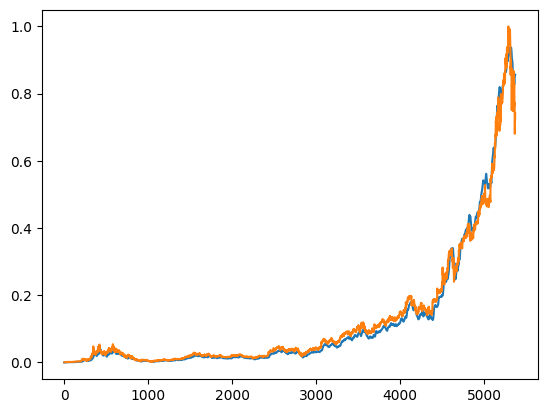

In [24]:
train_preds = model(x_train_tensor).detach().numpy()
plt.plot(train_preds)
plt.plot(y_train);

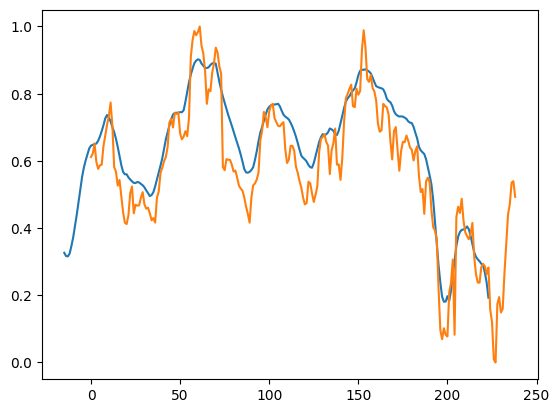

In [25]:
test_preds = model(x_test_tensor).detach().numpy()
sns.lineplot(x=np.arange(0,len(test_preds))-15, y=test_preds[:,0])
plt.plot(y_test);

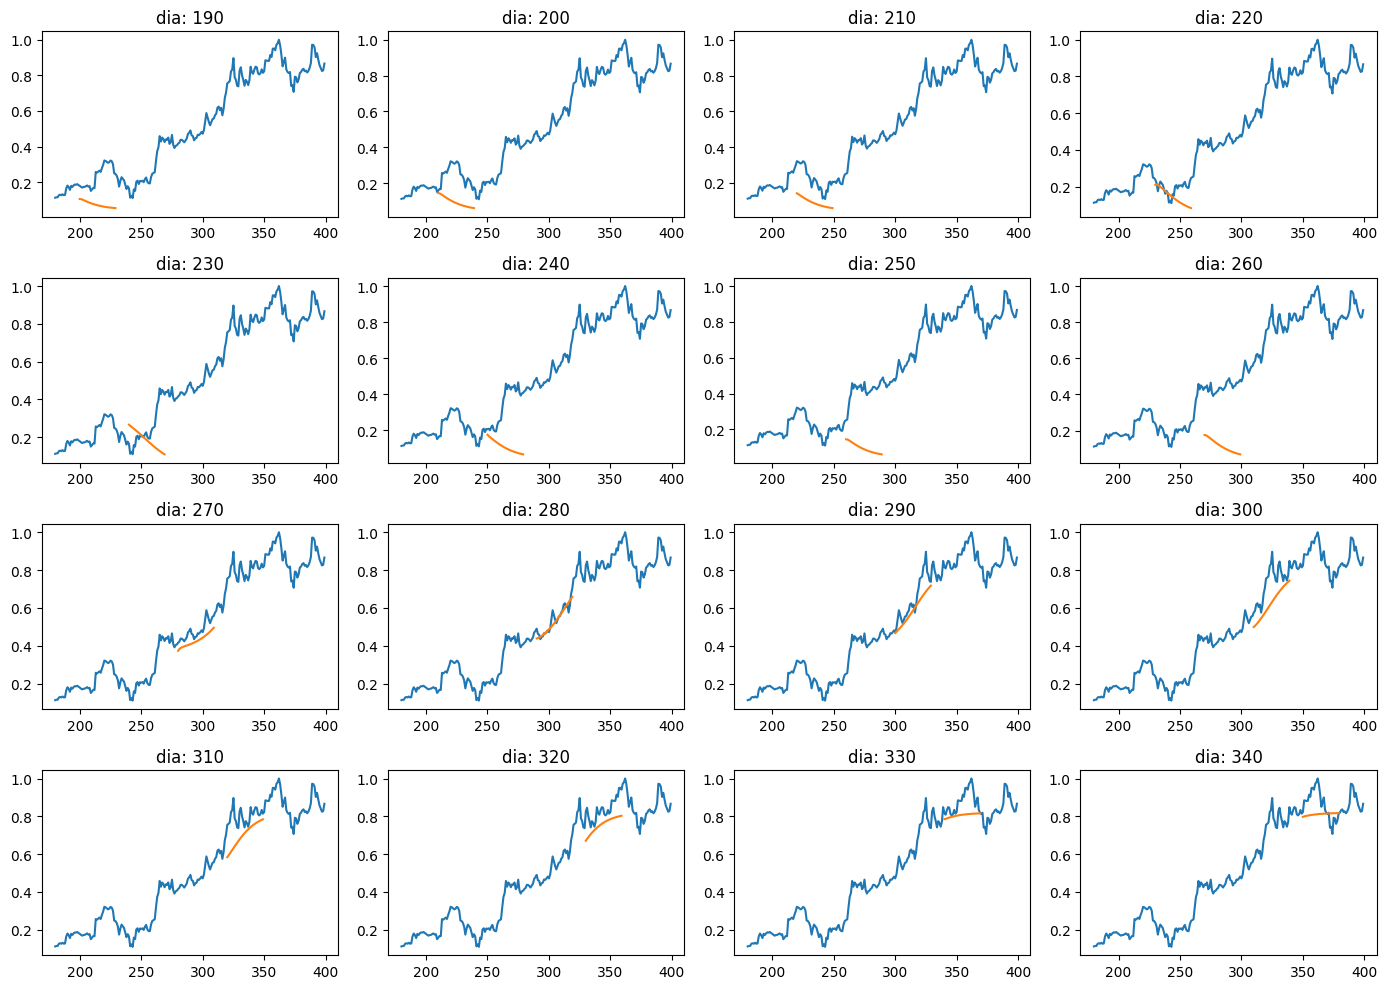

In [26]:
dia_a_predecir = 190
dias_a_predecir = 200
iterx = 10

fig, ax = plt.subplots(4, 4, figsize=(14, 10))
for _ in range(16):
    i = _ // 4
    j = _ % 4

    dia = dia_a_predecir + iterx * _
    predict_days = dias_a_predecir - iterx * _
    y0 = predict(dia, predict_days, modelo=model2)

    sns.lineplot(x=np.arange(dia_a_predecir - 10, dia_a_predecir + dias_a_predecir + 10), y=np.squeeze(y_val[dia_a_predecir-10:dia_a_predecir+dias_a_predecir+10]), legend=False, ax=ax[i, j])
    sns.lineplot(x=np.arange(dia+10, 10+dia + predict_days)[:30], y=y0[:30], label='Predictions', legend=False, ax=ax[i, j])

    ax[i, j].set_title(f"dia: {dia}")

plt.tight_layout()
plt.show()